In [8]:
import numpy as np
import pandas as pd
import requests

import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# 비선형 모델
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

# (선택) 불균형 대응
from sklearn.utils.class_weight import compute_class_weight

# 시각화 기본 설정(한글)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False


In [9]:
url = 'https://apis.data.go.kr/1480523/WaterQualityService/getWaterMeasuringList'
key = 'a6TS+sDQ+cPdv92zVxHz2EI1fV2sWy5kXdu9x/+QasyDSIU3105j6dts2lS2dnW7Y/YFXSw32QdOqyagGTCI8Q=='

In [10]:
# 2. 주소에 있던 파라미터 그대로 설정
params = {
    'serviceKey': key,
    'pageNo': '1',
    'numOfRows': '3000',
    'resultType': 'json',
    'ptNoList': '2022A30,2022A10', # 측정소 코드
    'wmyrList': '2021,2022,2023,2024,2025',      # 연도
    'wmodList': '01,02,03,04,05,06,07,08,09,10,11,12'        # 월(01, 02, 03월)
}

try:
    # 3. API 요청
    response = requests.get(url, params=params, verify=True) # https 대응
    
    if response.status_code == 200:
        data = response.json()
        
        # 4. 데이터 추출 (구조: getWaterMeasuringList -> item)
        items = data.get('getWaterMeasuringList', {}).get('item', [])
        
        if items:
            df = pd.DataFrame(items)
            # df.set_index('ROWNO',inplace=True)

            # 5. 주요 수질 항목 한글 이름으로 변경 (보기 좋게)
            rename_map = {
                'PT_NM': '총량지점명',
                'WMCYMD': '일자',
                'ITEM_TEMP': '수온', # 단위 : ℃
                'ITEM_PH': '수소이온농도(ph)',
                'ITEM_EC': '전기전도도(EC)',    # 단위 : μS/㎝
                'ITEM_DOC': '용존산소(DO)', # 단위 : ㎎/L
                'ITEM_BOD': 'BOD',  # 단위 : ㎎/L
                'ITEM_COD': 'COD',  # 단위 : ㎎/L
                'ITEM_SS': '부유물질',  # 단위 : ㎎/L
                'ITEM_TN': '총질소(T-N)',   # 단위 : ㎎/L
                'ITEM_TP': '총인(T-P)', # 단위 : ㎎/L
                'ITEM_TOC': '총유기탄소(TOC)',  # 단위 : ㎎/L
                'ITEM_AMNT': '유량',    # 단위 : ㎥/s
                'ITEM_CLOA': '클로로필-a'
            }
            
            # 2. 필요한 컬럼만 추출하여 새 DF 생성
            waterDF = df[list(rename_map.keys())].copy()
            waterDF.rename(columns=rename_map, inplace=True)

            # 3. 데이터 타입 숫자형으로 변환 (연산 가능하게)
            num_cols = ['수온', '수소이온농도(ph)', '전기전도도(EC)', '용존산소(DO)', 'BOD', 'COD', '부유물질', '총질소(T-N)', '총인(T-P)', '총유기탄소(TOC)', '유량','클로로필-a']
            waterDF[num_cols] = waterDF[num_cols].apply(pd.to_numeric, errors='coerce')

            # # 4. 날짜 데이터 형식 변환 (YYYYMMDD -> datetime)
            waterDF['일자'] = pd.to_datetime(waterDF['일자'], errors='coerce')

            print("--- 분석 준비 완료: 핵심 수질 지표 ---")
            print(waterDF.head())
        else:
            print("응답은 성공했으나 데이터가 없습니다.")
    else:
        print(f"API 요청 실패: {response.status_code}")

except Exception as e:
    print(f"오류 발생: {e}")

--- 분석 준비 완료: 핵심 수질 지표 ---
  총량지점명         일자   수온  수소이온농도(ph)  전기전도도(EC)  용존산소(DO)  BOD  COD  부유물질  \
0    물금 2021-01-04  4.6         7.5      437.0      13.1  1.7  5.1   2.4   
1    물금 2021-01-11  2.8         7.3      461.0      14.3  2.0  5.4   4.0   
2    물금 2021-01-26  5.1         7.2      470.0      15.6  2.1  6.0   7.6   
3    물금 2021-01-18  3.1         7.3      463.0      15.2  2.2  5.9   6.4   
4    물금 2021-02-16  6.6         8.4      451.0      12.1  2.8  6.6  12.4   

   총질소(T-N)  총인(T-P)  총유기탄소(TOC)      유량  클로로필-a  
0     3.223    0.025         3.8  29.555    12.4  
1     3.268    0.031         4.0  28.599    19.4  
2     3.416    0.026         4.6  74.897    47.3  
3     3.327    0.032         4.4  47.190    33.2  
4     3.489    0.027         5.0  72.735    50.4  


In [11]:
waterDF['년'] = waterDF['일자'].dt.year
waterDF['월'] = waterDF['일자'].dt.month

waterDF['지점'] = np.where(
    waterDF['총량지점명'].str.contains('물금', na=False), '물금',
    np.where(waterDF['총량지점명'].str.contains('금곡', na=False), '금곡', np.nan)
)

# 두 지점만 사용
waterDF = waterDF.dropna(subset=['지점']).copy()
waterDF['지점'].value_counts()

지점
물금    227
금곡    179
Name: count, dtype: int64

In [12]:
waterDF['녹조위험'] = pd.cut(
    waterDF['클로로필-a'],
    bins=[-np.inf, 10, 25, np.inf],
    labels=[0, 1, 2]   # 0=낮음, 1=보통, 2=높음
)

# 라벨 결측 제거 + int 변환
modelDF = waterDF.dropna(subset=['녹조위험']).copy()
modelDF['녹조위험'] = modelDF['녹조위험'].astype(int)

modelDF['녹조위험'].value_counts().sort_index()

녹조위험
0    107
1    154
2    143
Name: count, dtype: int64

In [13]:
feature_cols = [
    '총인(T-P)','총질소(T-N)','BOD','COD',
    '수온','유량','용존산소(DO)','전기전도도(EC)'
]

X = modelDF[feature_cols]
y = modelDF['녹조위험']

# 결측치가 있는 X 처리(중앙값 대체)
imputer = SimpleImputer(strategy='median')
X_imp = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_imp, y, test_size=0.2, random_state=42, stratify=y
)

# 1) RandomForest (추천)
rf = RandomForestClassifier(
    n_estimators=500,
    random_state=42,
    class_weight='balanced'
)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

print('[RandomForest]')
print(confusion_matrix(y_test, pred_rf))
print(classification_report(y_test, pred_rf))

# 2) GradientBoosting (비교용)
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)
pred_gb = gb.predict(X_test)

print('[GradientBoosting]')
print(confusion_matrix(y_test, pred_gb))
print(classification_report(y_test, pred_gb))


[RandomForest]
[[16  4  1]
 [ 2 16 13]
 [ 0  6 23]]
              precision    recall  f1-score   support

           0       0.89      0.76      0.82        21
           1       0.62      0.52      0.56        31
           2       0.62      0.79      0.70        29

    accuracy                           0.68        81
   macro avg       0.71      0.69      0.69        81
weighted avg       0.69      0.68      0.68        81

[GradientBoosting]
[[18  3  0]
 [ 4 16 11]
 [ 0 12 17]]
              precision    recall  f1-score   support

           0       0.82      0.86      0.84        21
           1       0.52      0.52      0.52        31
           2       0.61      0.59      0.60        29

    accuracy                           0.63        81
   macro avg       0.65      0.65      0.65        81
weighted avg       0.63      0.63      0.63        81



In [14]:
imp = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)
imp

BOD          0.179820
COD          0.148133
유량           0.126378
용존산소(DO)     0.125235
총질소(T-N)     0.109787
수온           0.108517
전기전도도(EC)    0.103962
총인(T-P)      0.098168
dtype: float64

In [ ]:
# 지점별 데이터 분리
feature_cols = [
    '총인(T-P)','총질소(T-N)','BOD','COD',
    '수온','유량','용존산소(DO)','전기전도도(EC)'
]

# 물금 / 금곡 분리
df_m = modelDF[modelDF['지점']=='물금'].copy()
df_g = modelDF[modelDF['지점']=='금곡'].copy()

X_m = df_m[feature_cols]
y_m = df_m['녹조위험']

X_g = df_g[feature_cols]
y_g = df_g['녹조위험']

print("물금:", y_m.value_counts().sort_index())
print("금곡:", y_g.value_counts().sort_index())

물금: 녹조위험
0    60
1    80
2    85
Name: count, dtype: int64
금곡: 녹조위험
0    47
1    74
2    58
Name: count, dtype: int64


In [ ]:
# 공통 전처리 + Train/Test Split
imputer = SimpleImputer(strategy='median')

# 물금
X_m_imp = imputer.fit_transform(X_m)
X_m_train, X_m_test, y_m_train, y_m_test = train_test_split(
    X_m_imp, y_m, test_size=0.2, random_state=42, stratify=y_m
)

# 금곡
X_g_imp = imputer.fit_transform(X_g)
X_g_train, X_g_test, y_g_train, y_g_test = train_test_split(
    X_g_imp, y_g, test_size=0.2, random_state=42, stratify=y_g
)

In [ ]:
# RandomForest 지점별 학습 & 성능 평가
def run_rf(X_train, X_test, y_train, y_test, label):
    rf = RandomForestClassifier(
        n_estimators=500,
        random_state=42,
        class_weight='balanced'
    )
    rf.fit(X_train, y_train)
    pred = rf.predict(X_test)

    print(f'\n[{label}]')
    print(confusion_matrix(y_test, pred))
    print(classification_report(y_test, pred))

    return rf

rf_m = run_rf(X_m_train, X_m_test, y_m_train, y_m_test, '물금')
rf_g = run_rf(X_g_train, X_g_test, y_g_train, y_g_test, '금곡')


[물금]
[[11  1  0]
 [ 2 10  4]
 [ 0  5 12]]
              precision    recall  f1-score   support

           0       0.85      0.92      0.88        12
           1       0.62      0.62      0.62        16
           2       0.75      0.71      0.73        17

    accuracy                           0.73        45
   macro avg       0.74      0.75      0.74        45
weighted avg       0.73      0.73      0.73        45


[금곡]
[[7 2 0]
 [4 8 3]
 [1 5 6]]
              precision    recall  f1-score   support

           0       0.58      0.78      0.67         9
           1       0.53      0.53      0.53        15
           2       0.67      0.50      0.57        12

    accuracy                           0.58        36
   macro avg       0.59      0.60      0.59        36
weighted avg       0.59      0.58      0.58        36



In [ ]:
# 지점별 중요 변수 추출
imp_m = pd.Series(rf_m.feature_importances_, index=feature_cols).sort_values(ascending=False)
imp_g = pd.Series(rf_g.feature_importances_, index=feature_cols).sort_values(ascending=False)

print('[물금 중요 변수]')
display(imp_m)

print('[금곡 중요 변수]')
display(imp_g)


[물금 중요 변수]


BOD          0.186425
COD          0.131846
용존산소(DO)     0.127393
유량           0.124373
수온           0.116394
총질소(T-N)     0.113249
전기전도도(EC)    0.106284
총인(T-P)      0.094036
dtype: float64

[금곡 중요 변수]


BOD          0.204145
COD          0.164374
용존산소(DO)     0.138999
유량           0.113336
수온           0.099544
총인(T-P)      0.094733
총질소(T-N)     0.094420
전기전도도(EC)    0.090449
dtype: float64

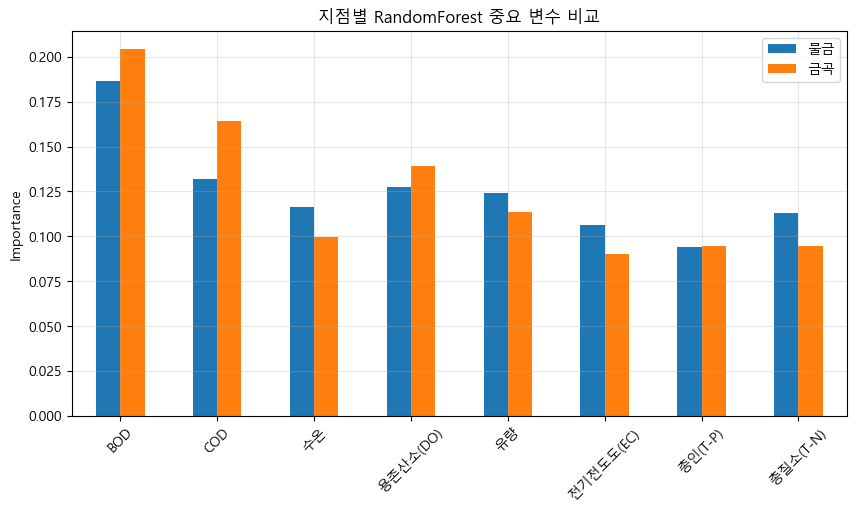

In [19]:
# 중요 변수 비교 시각화
impDF = pd.DataFrame({
    '물금': imp_m,
    '금곡': imp_g
})

impDF.plot(kind='bar', figsize=(10,5))
plt.title('지점별 RandomForest 중요 변수 비교')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.show()


## 해석 가이드 (보고서용 핵심 문장)
### 📌 성능 측면

“지점별로 모델을 분리한 결과, 금곡 지점의 예측 성능이 상대적으로 안정적이며,
물금 지점은 변수 간 상호작용이 더 복잡한 특성을 보였다.”

### 📌 변수 영향 측면

“물금 지점에서는 BOD, COD, 유량의 영향도가 높아
유기물·유량 조건에 민감한 녹조 발생 특성을 보였다.”

“금곡 지점에서는 총질소(T-N), 총인(T-P) 의 중요도가 높아
영양염 중심의 녹조 발생 메커니즘이 두드러졌다.”

### 👉 결론 한 줄

“녹조 발생 위험은 지점별로 지배 요인이 다르므로,
단일 모델보다 지점별 맞춤형 예측 모델과 관리 전략이 필요하다.”